In [1]:
import Pkg
Pkg.activate()
using FRESCO
using VacuumFields
using Plots
using FUSE
FUSE.logging(Logging.Info; actors=Logging.Info);

  Activating project at `~/.julia/environments/v1.10`
Precompiling FRESCO
  ✓ IMAS
  ✓ VacuumFields
  ✓ FRESCO
  3 dependencies successfully precompiled in 40 seconds. 406 already precompiled.
  1 dependency had output during precompilation:
┌ IMAS
│  WARNING: method definition for flux_gacode_to_fuse at /Users/lyons/.julia/dev/IMAS/src/physics/gacode_constants.jl:116 declares type variable N but does not use it.
└  
Precompiling FUSE
  ✓ FusionMaterials
  ✓ NEO
  ✓ BoundaryPlasmaModels
  ✓ TGLFNN
  ✓ FUSE
  5 dependencies successfully precompiled in 47 seconds. 634 already precompiled.


In [2]:
#dd,ini,act = FUSE.init(:ITER, init_from=:scalars);
#FUSE.ActorStationaryPlasma(dd,act);
#FUSE.save("/Users/lyons/.julia/dev/FRESCO/examples/ITER_case", dd, ini, act);

In [3]:
# run commands above instead (with proper directory) if necessary
dd,ini,act = FUSE.load("/Users/lyons/.julia/dev/FRESCO/examples/ITER_case");

In [4]:
coils = FUSE.IMAS_pf_active__coils(dd; green_model=:point, zero_currents=false);

In [5]:
function Ψ_vac(r, z)
    return sum(VacuumFields.ψ(coil, r, z) for coil in coils)
end

Ψ_vac (generic function with 1 method)

In [6]:
@time C = Canvas(dd, 129);
J(x,y) = FRESCO.initial_current(C, x, y);

  2.655343 seconds (5.64 M allocations: 375.502 MiB, 4.08% gc time, 99.53% compilation time)


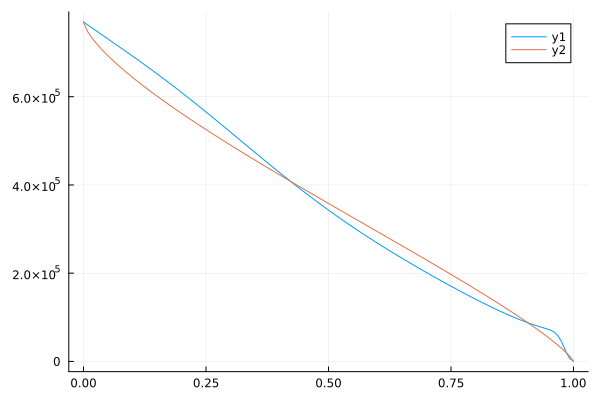

In [7]:
eq1d = dd.equilibrium.time_slice[].profiles_1d
psin = eq1d.psi_norm
paxis = eq1d.pressure[1]
alpha_m = 0.7
alpha_n = 0.8
profile = FRESCO.PaxisIp(paxis, alpha_m, alpha_n)

plot(psin, eq1d.pressure)
plot!(psin, paxis .* FRESCO.shape_function.(psin, Ref(profile)))

In [8]:
FRESCO.gridded_Jtor!(C, J)
for j in 1:2
    FRESCO.invert_GS_zero_bnd!(C); # this defines U for the boundary integral
    FRESCO.set_boundary_flux!(C, Ψ_vac)
    for i in 1:10
        @show j, i
        invert_GS!(C)
        FRESCO.update_bounds!(C)
        FRESCO.Jtor!(C, profile)
    end
    @show j, FRESCO.find_axis(C; update_Ψitp=false)
end

(j, i) = (1, 1)
(j, i) = (1, 2)
(j, i) = (1, 3)
(j, i) = (1, 4)
(j, i) = (1, 5)
(j, i) = (1, 6)
(j, i) = (1, 7)
(j, i) = (1, 8)
(j, i) = (1, 9)
(j, i) = (1, 10)
(j, FRESCO.find_axis(C; update_Ψitp = false)) = (1, (6.161483941419526, -0.24671923221699374, -88.86986287388112))
(j, i) = (2, 1)
(j, i) = (2, 2)
(j, i) = (2, 3)
(j, i) = (2, 4)
(j, i) = (2, 5)
(j, i) = (2, 6)
(j, i) = (2, 7)
(j, i) = (2, 8)
(j, i) = (2, 9)
(j, i) = (2, 10)
(j, FRESCO.find_axis(C; update_Ψitp = false)) = (2, (5.966244800399393, -1.229003389614384, -99.3330393043786))


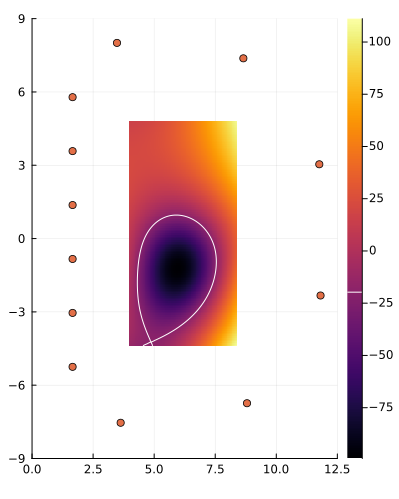

┌ Warning: /Users/lyons/.julia/dev/FUSE/src/actors/hcd/nbi is not an existing directory, Revise is not watching
└ @ Revise /Users/lyons/.julia/packages/Revise/doDG7/src/packagedef.jl:575


In [9]:
Rs, Zs = C.Rs, C.Zs
psi = deepcopy(C.Ψ);
using Plots
p1 = Plots.heatmap(Rs, Zs, psi', aspect_ratio=:equal, xrange=(0,12.5), yrange=(-9,9), size=(400,500))
Plots.plot!(p1, coils, label=nothing)
Plots.contour!(p1, Rs, Zs, psi', levels=[C.Ψbnd], color=:white)
display(p1)